# Identifying Age-Related Conditions w/ TFDF

In [1]:
!kaggle competitions download -c icr-identify-age-related-conditions

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


deeper dive into: [original source]( https://www.kaggle.com/code/gusthema/identifying-age-related-conditions-w-tfdf)

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel

https://www.tensorflow.org/decision_forests

In [2]:
from zipfile import ZipFile
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import polars as pl

with ZipFile('./icr-identify-age-related-conditions.zip', 'r') as zObject:
    zObject.extractall(path="./csv")

## Using Pandas

In [3]:
dataset_df = pd.read_csv("csv/train.csv")
print("Full train dataset shape is {}".format(dataset_df.shape))
dataset_df.head()


Full train dataset shape is (617, 58)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [5]:
dataset_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

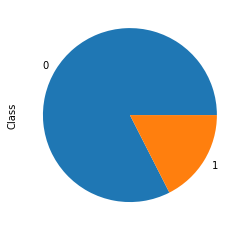

In [6]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

In [7]:
# Store all the numerical column names into a list
# list of column names that are not id, EJ, Class
NUM_FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]

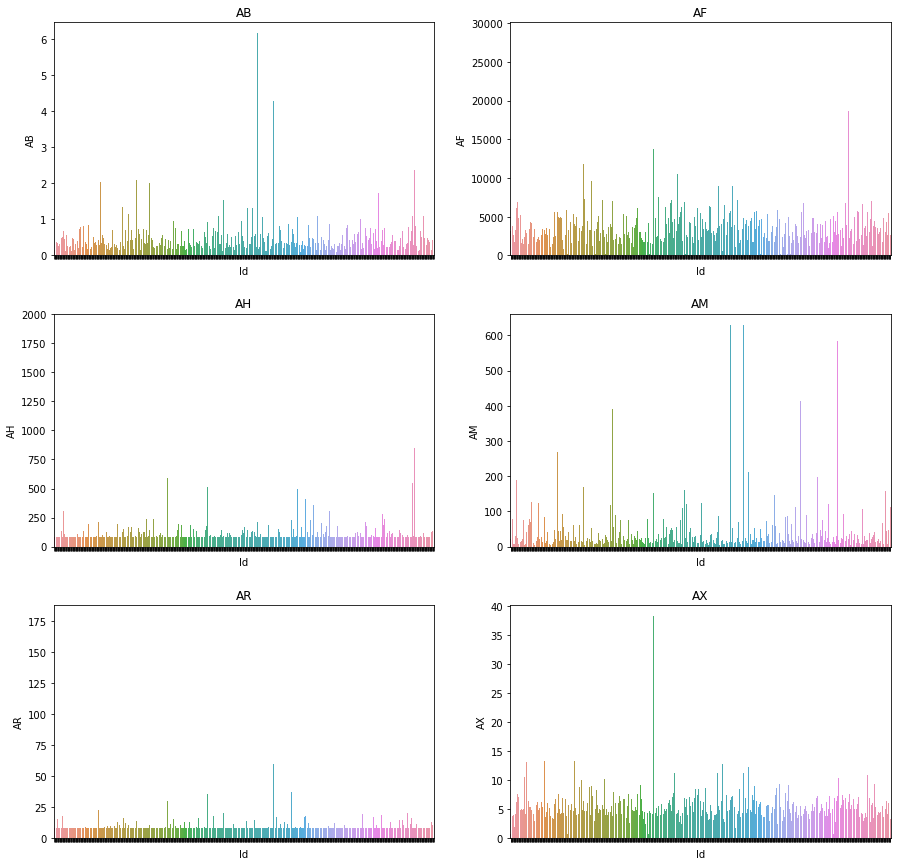

In [8]:
# sets up 3 x 2 plots of size 15 x 15 each
figure, axis = plt.subplots(3, 2, figsize=(15, 15))

# hspace: distance betweeb a plot and the one below
# wspace: distance betweeb a plot and the one right of it
plt.subplots_adjust(hspace=0.25, wspace=0.2)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
  # sneaky way to identify plots
  row = i // 2 # 0 0 1 1 2 2 . . .
  col = i % 2  # 0 1 0 1 0 1 . . .
  
  bp = sns.barplot(ax=axis[row, col], x=dataset_df['Id'], y=dataset_df[column_name])
  bp.set(xticklabels=[])
  axis[row, col].set_title(column_name)
plt.show()

In [9]:
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id"]]

In [10]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5)

### Out of Fold (OOF)

During KFold cross validation, the predictions made on the test set of each fold is known as Out of Fold(OOF) predictions. We will estimate the performance of the model using the predictions made across all the k (5 in this example) folds.

For our training loop, we will create a pandas dataframe named oof to store the predictions of the validation set during each fold.


In [11]:
# Create list of ids for the creation of oof dataframe.
ID_LIST = dataset_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST), 1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

### Select a Model

There are several tree-based models for you to choose from.

    RandomForestModel
    GradientBoostedTreesModel
    CartModel
    DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:


In [12]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get a better score.

You can select a template and/or set parameters as follows:

In [13]:
# random forest
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpnkny9dhs as temporary training directory


### Hyperparameter tuning to avoid overfitting

Because of the smaller size of the dataset, it is likely that the model will overfit during training. Numerous parameters, primarily max_depth and num_trees can be changed to fine-tune the model and prevent overfitting.

The attributemax_depth indicates the maximum depth of the tree. To avoid overfitting, we can try to reduce the depth of the tree from it's default value, which is 16. Another way to tackle overfitting is to increase the number of individual decision trees. To do this, we have to increase the value of the parameter num_trees from its default value(300).

You can set these parameters as follows:



In [14]:
rf = tfdf.keras.RandomForestModel(max_depth=5, num_trees=500)

Use /tmp/tmp79etu85z as temporary training directory


### Strategies to handle the dataset imbalance

Let's examine the fraction of positive and negative samples in this dataset's by examining theClass column.


In [16]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(dataset_df['Class'])
# Calculate total samples
total = neg + pos
print(f'Examples:\n    Total: {total}\n    Positive: {pos} ({100 * pos / total:.2f}% of total)\n')

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



As we can see, positive samples only account for 17.50% of the data. This means that our datastet is heavily imbalanced.

In classification problems with imbalanced datasets, a model tends to be more biased towards the majority class leading to the model performing poorly on the samples belonging to the minority class.

There are many techniques for dealing with imbalanced data. The most suitable techniques for this dataset are:

* Undersampling
* Class weighting

In this notebook we will use **Class weighting** to deal with imbalanced data. But first, we will quickly outline how undersampling can be performed.

### Undersampling

One approach to deal with an imbalanced dataset would be to under-sample the majority class(es) by choosing a smaller subset of the majority class samples(negative or `0` class in this case) from the dataset rather than picking the entire data.

Note: You have to loop through the dataset and try different random subsets for a better score.

The code snippet below illustrates how to perform undersampling.

In [19]:
# This function generates undersampled dataset.
def random_under_sampler(df):
  # Calculate the number of samples for each label. 
  neg, pos = np.bincount(df['Class'])

  # Choose the samples with class label `1`.
  one_df = df.loc[df['Class'] == 1] 
  # Choose the samples with class label `0`.
  zero_df = df.loc[df['Class'] == 0]
  # Select `pos` number of negative samples.
  # This makes sure that we have equal number of samples for each label.
  zero_df = zero_df.sample(n=pos)

  # Join both label dataframes.
  undersampled_df = pd.concat([zero_df, one_df])

  # Shuffle the data and return
  return undersampled_df.sample(frac = 1)


In [23]:
np.bincount(random_under_sampler(dataset_df)['Class'])
# this result shows equal number of pos and neg results, shuffled

array([108, 108])

### Class weighting

Since the postive(`1`) `Class` labels are only a small fraction of the dataset, we would want the classifier to heavily weight those examples. You can do this by passing **Keras weights** for each class through a parameter. This will cause the model to "pay more attention" to examples from an under-represented class. Read more about class weights [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights).

In [25]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

print('total:', total, 'neg:', neg, 'pos:', pos)

# Calculate the weight for each label.
# I think we are dividing total by 2 because we have 2 classes 
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

total: 617 neg: 509 pos: 108
Weight for class 0: 0.61
Weight for class 1: 2.86


To train and evaluate the models using class weights, use the dict in model.fit() as an argument as shown below.

```model.fit(x=train_ds, class_weight=class_weight)```

### Train Random Forest Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [33]:
for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
  train_df = dataset_df.iloc[train_index]
  valid_df = dataset_df.iloc[valid_index]
  valid_ids = valid_df.index.values
  
  print('df:', valid_df)
  print('ids:', valid_ids)
  break



df:                Id        AB          AF          AH         AM         AR  \
0    000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407   8.138688   
1    007255e47698  0.145282   978.76416   85.200147  36.968889   8.138688   
2    013f2bd269f5  0.470030  2635.10654   85.200147  32.360553   8.138688   
3    043ac50845d5  0.252107  3819.65177  120.201618  77.112203   8.138688   
4    044fb8a146ec  0.380297  3733.04844   85.200147  14.103738   8.138688   
..            ...       ...         ...         ...        ...        ...   
119  2fd659800f75  0.405935  1011.87218   91.122267  69.840447   8.138688   
120  30202b353d8a  0.235015  7233.17430   85.200147   5.562212   8.138688   
121  3026974712cd  1.140891  1649.24331  170.365458  59.549116  10.545684   
122  3101fca6b743  0.521306  5674.69551  119.918575  34.726661   8.138688   
123  312661adb2ff  0.670861  1418.86415  124.294848  16.237571  10.792152   

           AX        AY         AZ          BC  ...         FL        F

In [63]:
# Loop through each fold
# kf generates 5 folds, 
# i represents the number of the fold 1 ... 5
# train_index is all 617 of the data
# valid_index is the data divided by 5, each i will have 1/5 of the data in the valid_index
for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
  print('##### Fold',i+1)

  # .iloc fetches the values associated with dataset_df using the indices array
  train_df = dataset_df.iloc[train_index]
  valid_df = dataset_df.iloc[valid_index]
  valid_ids = valid_df.index.values # these are just indices
  
  # Select only feature columns for training.
  train_df = train_df[FEATURE_COLUMNS]
  valid_df = valid_df[FEATURE_COLUMNS]
  
  # There's one more step required before we can train the model. 
  # We need to convert the datatset from Pandas format (pd.DataFrame)
  # into TensorFlow Datasets format (tf.data.Dataset).
  # TensorFlow Datasets is a high performance data loading library 
  # which is helpful when training neural networks with accelerators like GPUs and TPUs.
  # Note: Some column names contains white spaces at the end of their name, 
  # which is non-comaptible with SavedModels save format. 
  # By default, `pd_dataframe_to_tf_dataset` function will convert 
  # this column names into a compatible format. 
  # So you can safely ignore the warnings related to this.
  print(label)
  print(train_df)
  print(FEATURE_COLUMNS)
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
  valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

  # Define the model and metrics
  rf = tfdf.keras.RandomForestModel()
  rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
  
  # Train the model
  # We will train the model using a one-liner.
  # Note: you may see a warning about Autograph. 
  # You can safely ignore this, it will be fixed in the next release.
  # Previously calculated class weights is used to handle imbalance.
  rf.fit(x=train_ds, class_weight=class_weight)
  
  # Store the model
  models[f"fold_{i+1}"] = rf
  
  
  # Predict OOF value for validation data
  predict = rf.predict(x=valid_ds)
  
  # Store the predictions in oof dataframe
  oof.loc[valid_ids, 0] = predict.flatten() 
  
  # Evaluate and store the metrics in respective dicts
  evaluation = rf.evaluate(x=valid_ds,return_dict=True)
  accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
  cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

##### Fold 1
Class
           AB          AF          AH          AM         AR        AX  \
124  0.440119  1466.48370  123.911652    4.803447   8.138688  5.076207   
125  0.499941  4402.36962  149.925435   24.107048   8.138688  6.046267   
126  0.717864  2394.81143  167.434879   32.171636   8.138688  4.367487   
127  0.423027  3087.34162   85.200147   20.276059   8.138688  3.313266   
128  0.529852  3287.77933   85.200147   22.632876   8.138688  8.726115   
..        ...         ...         ...         ...        ...       ...   
612  0.149555  3130.05946  123.763599    9.513984  13.020852  3.499305   
613  0.435846  5462.03438   85.200147   46.551007  15.973224  5.979825   
614  0.427300  2459.10720  130.138587   55.355778  10.005552  8.070549   
615  0.363205  1263.53524   85.200147   23.685856   8.138688  7.981959   
616  0.482849  2672.53426  546.663930  112.006102   8.138688  3.198099   

           AY         AZ        BC         BD   ...         FL       FR  \
124  0.025578   7

Use /tmp/tmp0lujkbhl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.682809. Found 493 examples.
Training model...
Model trained in 0:00:00.092695
Compiling model...
Model compiled.
1/1 [==============================] - 0s 204ms/step - loss: 0.0000e+00 - accuracy: 0.9516 - binary_crossentropy: 0.2182
##### Fold 2
Class
           AB          AF          AH          AM         AR        AX  \
0    0.209377  3109.03329   85.200147   22.394407   8.138688  0.699861   
1    0.145282   978.76416   85.200147   36.968889   8.138688  3.632190   
2    0.470030  2635.10654   85.200147   32.360553   8.138688  6.732840   
3    0.252107  3819.65177  120.201618   77.112203   8.138688  3.685344   
4    0.380297  3733.04844   85.200147   14.103738   8.138688  3.942255   
..        ...         ...         ...         ...        ...       ...   
612  0.149555  3130.05946  123.763599    9.513984  13.020852  3.499305   
613  0.435846  5462.03438   85.200147   4

Use /tmp/tmpw09ilv4v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.577856. Found 493 examples.
Training model...
Model trained in 0:00:00.083293
Compiling model...
Model compiled.
1/1 [==============================] - 0s 249ms/step - loss: 0.0000e+00 - accuracy: 0.8790 - binary_crossentropy: 0.2608
##### Fold 3
Class
           AB          AF          AH          AM         AR        AX  \
0    0.209377  3109.03329   85.200147   22.394407   8.138688  0.699861   
1    0.145282   978.76416   85.200147   36.968889   8.138688  3.632190   
2    0.470030  2635.10654   85.200147   32.360553   8.138688  6.732840   
3    0.252107  3819.65177  120.201618   77.112203   8.138688  3.685344   
4    0.380297  3733.04844   85.200147   14.103738   8.138688  3.942255   
..        ...         ...         ...         ...        ...       ...   
612  0.149555  3130.05946  123.763599    9.513984  13.020852  3.499305   
613  0.435846  5462.03438   85.200147   4

Use /tmp/tmpzx_u_7fv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.597358. Found 494 examples.
Training model...
Model trained in 0:00:00.087181
Compiling model...
Model compiled.
1/1 [==============================] - 0s 216ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2741
##### Fold 4
Class
           AB          AF          AH          AM         AR        AX  \
0    0.209377  3109.03329   85.200147   22.394407   8.138688  0.699861   
1    0.145282   978.76416   85.200147   36.968889   8.138688  3.632190   
2    0.470030  2635.10654   85.200147   32.360553   8.138688  6.732840   
3    0.252107  3819.65177  120.201618   77.112203   8.138688  3.685344   
4    0.380297  3733.04844   85.200147   14.103738   8.138688  3.942255   
..        ...         ...         ...         ...        ...       ...   
612  0.149555  3130.05946  123.763599    9.513984  13.020852  3.499305   
613  0.435846  5462.03438   85.200147   4

Use /tmp/tmp_9us5ugq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.577092. Found 494 examples.
Training model...
Model trained in 0:00:00.086267
Compiling model...
Model compiled.
1/1 [==============================] - 0s 217ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2717
##### Fold 5
Class
           AB          AF          AH         AM        AR         AX  \
0    0.209377  3109.03329   85.200147  22.394407  8.138688   0.699861   
1    0.145282   978.76416   85.200147  36.968889  8.138688   3.632190   
2    0.470030  2635.10654   85.200147  32.360553  8.138688   6.732840   
3    0.252107  3819.65177  120.201618  77.112203  8.138688   3.685344   
4    0.380297  3733.04844   85.200147  14.103738  8.138688   3.942255   
..        ...         ...         ...        ...       ...        ...   
489  0.371751  2072.22301  120.532560   5.373295  8.138688   4.296615   
490  0.474303  4877.54146   85.200147  34.996100 

Use /tmp/tmputc2un_n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.555797. Found 494 examples.
Training model...
Model trained in 0:00:00.085173
Compiling model...
Model compiled.
1/1 [==============================] - 0s 218ms/step - loss: 0.0000e+00 - accuracy: 0.9512 - binary_crossentropy: 0.2172


### Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select any tree for display.

Let us pick one model from the `models` dict and select a tree for display.

In [44]:
tfdf.model_plotter.plot_model(models['fold_1'], tree_idx=0, max_depth=3)

'\n<script src="https://d3js.org/d3.v6.min.js"></script>\n<div id="tree_plot_3f4bec9e6917472cafb6de4f5b15e0c3"></div>\n<script>\n/*\n * Copyright 2021 Google LLC.\n * Licensed under the Apache License, Version 2.0 (the "License");\n * you may not use this file except in compliance with the License.\n * You may obtain a copy of the License at\n *\n *     https://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an "AS IS" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\n\n/**\n *  Plotting of decision trees generated by TF-DF.\n *\n *  A tree is a recursive structure of node objects.\n *  A node contains one or more of the following components:\n *\n *    - A value: Representing the output of the node. If the node is not a leaf,\

### Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training, we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model. The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the `binary_crossentropy` evaluated on the out of bag dataset according to the number of trees in the model. Let us plot this for the models of each fold.

Note: Smaller values are better for this hyperparameter.

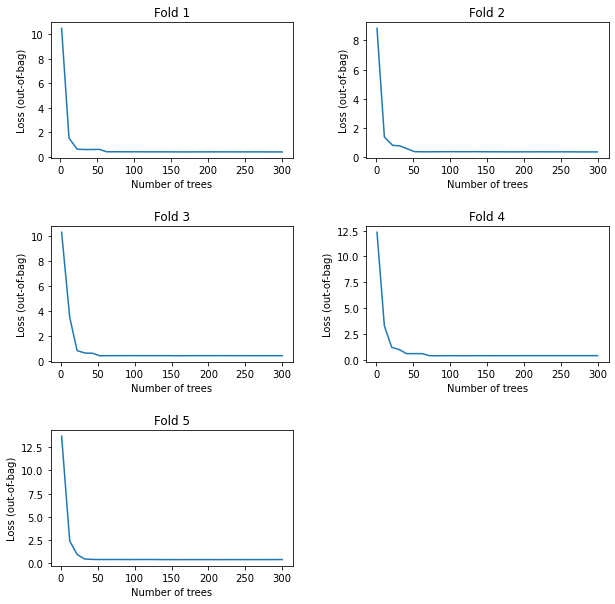

In [48]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

# this deletes the 6th plot since it is empty 
axis[2][1].set_visible(False)
plt.show()

We can also see some general stats on the OOB dataset:

In [49]:
for _model in models:
    inspector = models[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=493, accuracy=0.83384120423487, loss=0.40094491626713946, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=493, accuracy=0.86791143186256, loss=0.374230902610848, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=494, accuracy=0.8625237360976467, loss=0.39912028399338717, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=494, accuracy=0.8742180068903357, loss=0.38689070260817593, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=494, accuracy=0.8477430594687857, loss=0.39049966583287166, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


Now, let us check the evaluation metrics for each fold and its average value.

In [51]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9516 loss: 0.2182
fold_2: acc: 0.8790 loss: 0.2608
fold_3: acc: 0.9024 loss: 0.2741
fold_4: acc: 0.9024 loss: 0.2717
fold_5: acc: 0.9512 loss: 0.2172

Average accuracy: 0.9173  Average loss: 0.2484


### Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests. Let us pick one model from models dict and inspect it.

Let us list the available `Variable Importances` for Decision Trees:

In [52]:
inspector = models['fold_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [53]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("DU" (1; #32), 47.0),
 ("DI" (1; #29), 25.0),
 ("DA" (1; #25), 21.0),
 ("AB" (1; #0), 19.0),
 ("FL" (1; #47), 19.0),
 ("GL" (1; #55), 18.0),
 ("BQ" (1; #12), 16.0),
 ("CR" (1; #21), 16.0),
 ("FD_" (1; #44), 16.0),
 ("CD_" (1; #17), 14.0),
 ("AF" (1; #1), 13.0),
 ("CC" (1; #16), 8.0),
 ("DF" (1; #27), 7.0),
 ("AR" (1; #4), 6.0),
 ("DH" (1; #28), 6.0),
 ("EB" (1; #35), 6.0),
 ("FI" (1; #46), 6.0),
 ("BC" (1; #8), 5.0),
 ("EH" (1; #38), 5.0),
 ("FR" (1; #48), 5.0),
 ("DE" (1; #26), 4.0),
 ("DL" (1; #30), 4.0),
 ("EE" (1; #36), 4.0),
 ("FE" (1; #45), 4.0),
 ("EU" (1; #42), 3.0),
 ("BN" (1; #10), 2.0),
 ("EL" (1; #40), 1.0)]

### Submission

In [56]:
test_df = pd.read_csv('./csv/test.csv')
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.tolist()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
                        if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd)
predictions = models['fold_1'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)

1/1 [==============================] - 0s 102ms/step
[[0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643]]


In [57]:
sample_submission = pd.read_csv("./csv/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('./csv/submission.csv', index=False)

In [58]:
submission = pd.read_csv("./csv/submission.csv")
submission

,Id,class_0,class_1
0,00eed32682bb,0.653334,0.346666
1,010ebe33f668,0.653334,0.346666
2,02fa521e1838,0.653334,0.346666
3,040e15f562a2,0.653334,0.346666
4,046e85c7cc7f,0.653334,0.346666
